In [1]:
import os
import glob
import cv2
import numpy as np
import matplotlib.pyplot as plt
import json
import random
from tqdm import tqdm

from collections import defaultdict, namedtuple

from IPython.display import clear_output

%matplotlib inline
plt.rcParams["figure.figsize"] = (15, 14) # (w, h)

In [2]:
from mtcnn.mtcnn import MTCNN
import cvlib

class MTCNNDetector:
    """MTCNNDetector"""
    def __init__(self):
        self.model = MTCNN()
    
    def detect_faces(self, img):
        faces = self.model.detect_faces(img)
        faces = [x['box'] for x in faces]
        return faces

def rect_to_bb(rect):
    x1, y1, x2, y2 = rect
    return (x1, y1, x2-x1, y2-y1)

class CVLibDetector:
    "CVLibDetector"
    def __init__(self):
        return
    
    def detect_faces(self, img):
        face_rects, confidences = cvlib.detect_face(img)
        faces = [rect_to_bb(face_rect) for face_rect in face_rects]
        return faces

mtcnn_detector = MTCNNDetector()
cvlib_detector = CVLibDetector()
detectors = [
    (mtcnn_detector, 'cache.pickle'),
    (cvlib_detector, 'yolo_cache.pickle')
]

from keras_facenet import FaceNet
embedder = FaceNet()
clear_output()

In [3]:
face_detector, cache_file = detectors[0]
metadata_filename = 'metadata.json'
events_path = os.path.join('data', 'CVDataset')

In [4]:
from utils import load_image, load_images, load_face_information, cache_face_information, load_image, cache_face_information, use_tqdm, ImageLoader

In [5]:
def encode_face(img):
    location = locate_faces(img)[:1]
    face_img = extract_faces(img, location)
    return embedder.embeddings(face_img)[0]

def encode_faces(img, locations):
    if not len(locations):
        return np.array([])
    return embedder.embeddings(extract_faces(img, locations))

def extract_faces(img, locations):
    res_imgs = []
    for (y1, x1, y2, x2) in locations:
        res_imgs.append(img[y1:y2, x2:x1])
    return res_imgs

def draw_faces(img, locations, verbose=True, title=None):
    res_img = img.copy()
    for (y1, x1, y2, x2) in locations:
        cv2.rectangle(res_img, (x1, y2), (x2, y1), (0, 255, 0), 4)
    if verbose:
        plt.imshow(res_img)
        plt.title(title)
        plt.show()
    return res_img

def locate_faces(img):
    faces = face_detector.detect_faces(img)
    faces = [(max(y, 0),
              min(x+w, img.shape[1]),
              min(y+h, img.shape[0]),
              max(x, 0)) for x, y, w, h in faces 
             if y < img.shape[0] and x < img.shape[1]]
    return np.array(faces)

def face_distance(face1, face2):
    return np.linalg.norm(face1 - face2, axis=1)

def compare_faces(face1, face2, tolerance=None):
    tolerance = tolerance or 0.9
    return list(face_distance(face1, face2) <= tolerance)

In [6]:
class Person:
    def __init__(self, imgs, name):
        self.imgs = imgs
        self.name = name
        self.encodings = [encode_face(img).reshape(1, -1) for img in imgs]

# Load photo with the person
people = [
    Person([load_image(os.path.join('data', img)) for img in [
                                                              'boris.jpg',
                                                              'boris_2.jpg',
#                                                               'boris_3.jpg',
#                                                               'boris_4.jpg',
#                                                              'boris_c1.jpg', 'boris_c2.jpg', 'boris_c3.jpg'
                                                             ]], 'Boris'),
#     Person([load_image(os.path.join('data', img)) for img in ['ivan.jpg', 'ivan_2.jpg']], 'Ivan'),
    Person([load_image(os.path.join('data', img)) for img in ['vlad.jpg', 'vlad_2.jpg']], 'Vlad'),
#     Person([load_image(os.path.join('data', img)) for img in ['denis.jpg']], 'Denis'),
#     Person([load_image(os.path.join('data', img)) for img in ['andrey.jpg']] 'Andrey'),
]

person = people[0]

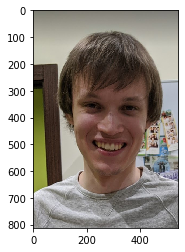

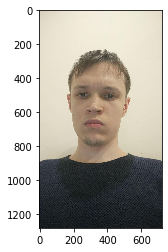

In [7]:
for img in person.imgs:
    plt.imshow(img[:, :, ::-1])
    plt.show()

In [8]:
# List folders
glob_path = os.path.join(events_path, '*')
folders = glob.glob(glob_path)
images = ImageLoader(glob_path)
# folders.remove('data\\CVDataset\\Vlad')
# folders.remove('data\\CVDataset\\Boris')
print(np.array(folders))

['data\\CVDataset\\23_8 InnoClubFest 2017'
 'data\\CVDataset\\Aerotube sweets' 'data\\CVDataset\\Boris'
 'data\\CVDataset\\Club Fest, Fall 2018' 'data\\CVDataset\\Halloween 2017'
 'data\\CVDataset\\Halloween 2018'
 'data\\CVDataset\\Slippers of the Year 2018'
 'data\\CVDataset\\Slippers of the Year 2019' 'data\\CVDataset\\Vlad']


In [9]:
events_metadata = defaultdict(set)
for folder in folders:
    with open(os.path.join(folder, metadata_filename)) as metadata_file:
        event_metadata = json.loads(metadata_file.read())
    for k, v in event_metadata.items():
        events_metadata[k].update([os.path.join(folder, vi) for vi in v])
len(events_metadata)

4

In [10]:
list(events_metadata.keys())

['boris', 'noone', 'vlad', 'ivan']

In [11]:
def process_images(images, scale=0.5, desc="Processing faces in images"):
    """Get face locations and encodings from given images."""
    face_info = dict()
    for i, (img_name, img) in use_tqdm(enumerate(images),
                                       desc=desc,
                                       total=len(images)):
        # Scale down for faster processing
        small_img = cv2.resize(img, (0, 0), fx=scale, fy=scale)

        # Face detection
        face_locations = locate_faces(small_img)
        if len(face_locations) == 0:
            # Ignoring empty
            face_encodings = []
        else:
            # Face extraction
            face_encodings = encode_faces(small_img, face_locations)
        
        # Scale locations back
        face_locations = scale_locations(face_locations, 1 / scale)
        
        face_info[img_name] = {
            'locations': face_locations,
            'encodings': face_encodings
        }
    return face_info

def scale_locations(locations, scale=2):
    return (locations * scale).astype(int)
    for i, loc in enumerate(locations):
        for j, coord in enumerate(loc):
            locations[i, j] = int(coord * scale)
    return locations

face_info = defaultdict(dict)
for folder in folders:
    cache_path = os.path.join(folder, cache_file)
    if os.path.exists(cache_path):
        face_info[folder] = load_face_information(cache_path)
        print('Loaded cached data')
    else:
        face_info[folder] = process_images(ImageLoader(folder))
        cache_face_information(face_info[folder], cache_path)

Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data
Loaded cached data


In [12]:
def calc_stats(predicted, real):
    accuracy = len(real.intersection(predicted)) / len(predicted) if len(predicted) else 0.
    recall = len(real.intersection(predicted)) / len(real) if len(real) else 0.
    return accuracy, recall

In [13]:
def compare_img_to_set(face_encoding, face_information, tolerance=None):
    images_with_person = dict()
    for i, (img_name, face_info) in enumerate(face_information.items()):

        if len(face_info['locations']) == 0 or len(face_info['encodings']) == 0:
            continue

        matches = compare_faces(face_encoding, face_info['encodings'], tolerance)

        if any(matches):
            images_with_person[img_name] = face_info['locations'][matches]
    return images_with_person

def get_stats(results, person_name, verbose=True):
    img_paths = list(map(os.path.normpath, results))
    acc, recall = calc_stats(img_paths, events_metadata[person_name.lower()])
    if verbose:
        print(f"""Found {len(results)} images with {person.name}.
        Accuracy: {acc: <4.3}
        Recall:   {recall: <4.3}
        """)
    return img_paths, acc, recall

## Compare different Face Comparison methods

### Union of recognition
взяты все фото для 2х лиц одного человека (union)

In [14]:
results = []
for person in people:
    result = dict()
    for folder in folders:
        for encoding in person.encodings:
            result.update(compare_img_to_set(encoding, face_info[folder]))
    
    img_paths, acc, recall = get_stats(result, person.name, verbose=True)
    results.append({'res':result, 'acc':acc, 'recall':recall})

mean_acc = np.mean(list(map(lambda x:x['acc'], results)))
mean_recall = np.mean(list(map(lambda x:x['recall'], results)))
print(f"""
Mean accuracy: {mean_acc: <4.3}
Mean recall:   {mean_recall: <4.3}""")

Found 56 images with Boris.
        Accuracy: 0.732
        Recall:   0.707
        
Found 28 images with Vlad.
        Accuracy: 0.929
        Recall:   0.433
        

Mean accuracy: 0.83
Mean recall:   0.57


### Intersection of recognition
взяты общие фото для 2х лиц одного человека (intersection)

In [15]:
results = []
for person in people:
    common = None
    for encoding in person.encodings:
        result = dict()
        for folder in folders:
            result.update(compare_img_to_set(encoding, face_info[folder]))
        if common is None:
            common = set(result.keys())
        else:
            common.intersection_update(set(result.keys()))
    
    # filter results
    tmp = dict()
    for k in common:
        tmp[k] = result[k]
    result = tmp
    
    img_paths, acc, recall = get_stats(result, person.name)
    results.append({'res':result, 'acc':acc, 'recall':recall})


mean_acc = np.mean(list(map(lambda x:x['acc'], results)))
mean_recall = np.mean(list(map(lambda x:x['recall'], results)))
print(f"""
Mean accuracy: {mean_acc: <4.3}
Mean recall:   {mean_recall: <4.3}""")

Found 42 images with Boris.
        Accuracy: 0.929
        Recall:   0.672
        
Found 12 images with Vlad.
        Accuracy: 1.0 
        Recall:   0.2 
        

Mean accuracy: 0.964
Mean recall:   0.436


### Mean vector
взят средний вектор

In [16]:
results = []
for person in people:
    mean_encoding = np.array(person.encodings).mean(axis=0)
    result = dict()
    for folder in folders:
        result.update(compare_img_to_set(mean_encoding, face_info[folder]))
    
    img_paths, acc, recall = get_stats(result, person.name)
    results.append({'res':result, 'acc':acc, 'recall':recall})

mean_acc = np.mean(list(map(lambda x:x['acc'], results)))
mean_recall = np.mean(list(map(lambda x:x['recall'], results)))
print(f"""
Mean accuracy: {mean_acc: <4.3}
Mean recall:   {mean_recall: <4.3}""")

Found 66 images with Boris.
        Accuracy: 0.652
        Recall:   0.741
        
Found 45 images with Vlad.
        Accuracy: 0.689
        Recall:   0.517
        

Mean accuracy: 0.67
Mean recall:   0.629


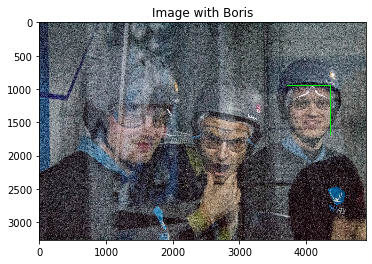

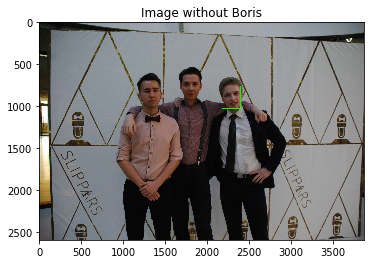

In [19]:
people_ind = 0
result = results[people_ind]['res']
person = people[people_ind]
images_with_person = list(events_metadata[person.name.lower()].intersection(result))
images_withot_person = list(set(result).difference(events_metadata[person.name.lower()]))

if len(images_with_person):
    image_path = random.choice(images_with_person)
    face_loc = result[image_path]
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, face_loc, title=f'Image with {person.name}')
else:
    print('No images with', person.name)


if len(images_withot_person): 
    image_path = random.choice(images_withot_person)
    face_loc = result[image_path]
    img = load_image(image_path)[:, :, ::-1]
    draw_faces(img, face_loc, title=f'Image without {person.name}')
else:
    print('No images without', person.name)